In [1]:
import torch
import skimage.io as io
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
import pandas as pd

import sys
sys.stdout = open('prints.txt', 'w')

import skimage.io as io
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd


In [2]:
from utils import *
def save_path_generator(**kwargs):
    assert 'image_path' in kwargs.keys(), 'image_path is not provided'
    if len(kwargs['image_path']) > 1:
        file_name = os.path.splitext(os.path.basename(kwargs['image_path'][0]))[0]
        folder = os.path.basename(os.path.dirname(kwargs['image_path'][0]))
    else:
        file_name = os.path.splitext(os.path.basename(kwargs['image_path']))[0]
        folder = os.path.basename(os.path.dirname(kwargs['image_path']))
    init_path = os.getcwd() + '/data/saved_weights/' + folder + '/'
    save_wpath = os.getcwd() + '/data/retrieved/' + folder + '/'
    if not os.path.exists(init_path):
        os.makedirs(init_path)
    if not os.path.exists(save_wpath):
        os.makedirs(save_wpath)
    kwargs['file_name'] = file_name
    kwargs['save_wpath'] = save_wpath
    kwargs['init_wpath'] = init_path
    return kwargs 

def get_all_info(path = None, images = None, idx = 1000, energy_kev = 18.0, detector_pixel_size = 2.57 * 1e-6, distance_sample_detector = 0.15, alpha = 1e-8, delta_beta = 1e1, pad = 1, method = 'TIE', image = None, phase_path= None, attenuation_path = None, phase_image = None, attenuation_image = None, **kwargs):
    """
    make sure that the unit of energy is in keV, the unit of detector_pixel_size is in meter, and the unit of distance_sample_detector is in meter
    """
    if path is not None:
        images = list(io.imread_collection(path + '/*.tif').files)
        # images = sorted(glob(path + '/*.tif'))
        if type(idx) is list:
            image_path = [images[i] for i in idx]
            image = load_images_parallel(image_path)
            shape_x = image[0].shape[0]
            shape_y = image[0].shape[1]
            Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
            ND = len(idx)
            print("images are of leng", len(image))
            std = [np.std(i) for i in image]
            mean = [np.mean(i) for i in image]
        else:
            image_path = images[idx]
            image = load_image(image_path)
            shape_x = image.shape[0]
            shape_y = image.shape[1]
            Fx, Fy = grid_generator(shape_x, shape_y, upscale=pad, ps = detector_pixel_size)
            ND = 1
            std = [np.std(image)]
            mean = [np.mean(image)]
        assert images is not None, "either image or path should be provided"
        
    else:
        assert images is not None, "either image or path should be provided"
        image_path = images[idx]
        image = load_image(images[idx])
        Fx, Fy = grid_generator(image.shape[0], image.shape[1], upscale=1, ps = detector_pixel_size)
        shape_x = image.shape[0]
        shape_y = image.shape[1]
        ND = 1
        std = [np.std(image)]
        mean = [np.mean(image)]
    
    
    if phase_path is not None and attenuation_path is not None:
        phase_images = io.imread_collection(phase_path + '/*.tif').files
        attenuation_images = io.imread_collection(attenuation_path + '/*.tif').files
        if type(idx) is list:
            phase_image_path = []
            attenuation_image_path = []
            for i in idx:
                phase_image_path.append(phase_images[i])
                attenuation_image_path.append(attenuation_images[i])
            phase_image = load_images_parallel(phase_image_path)
            attenuation_image = load_images_parallel(attenuation_image_path)
        else:
            phase_image_path = phase_images[idx]
            attenuation_image_path = attenuation_images[idx]
            phase_image = load_image(phase_image_path)
            attenuation_image = load_image(attenuation_image_path)

    kwargs = {
        "path": path,
        "output_path" : os.getcwd(),
        "idx": idx,
        "column_name": 'path',
        "energy_J": energy_kev_to_joule(energy_kev),
        "energy_kev": energy_kev,
        "lam": wavelength_from_energy(energy_kev),
        "detector_pixel_size": detector_pixel_size,
        "distance_sample_detector": detector_pixel_size,
        "fresnel_number": fresnel_calculator(energy_kev = energy_kev, detector_pixel_size = detector_pixel_size, distance_sample_detector = distance_sample_detector),
        "wave_number": wave_number(energy_kev),

        "shape_x": shape_x,
        "shape_y": shape_y,
        "pad_mode": 'symmetric',
        'shape': [int(shape_x), int(shape_y)],
        'nx': int(shape_x), 'ny': int(shape_y),
        'distance': [distance_sample_detector], 
        'energy': energy_kev, 
        'alpha': alpha, 
        'pad': pad,
        'nfx': int(shape_x) * pad, 
        'nfy': int(shape_y) * pad,
        'pixel_size': [detector_pixel_size, detector_pixel_size],
        'sample_frequency': [1.0/detector_pixel_size, 1.0/detector_pixel_size],
        'fx': Fx, 'fy': Fy,
        'method': method, 
        'delta_beta': delta_beta,

        "image_path": image_path,
        "image": image,
        "images": images,
        "ND": ND,
        "std": std,
        "mean": mean,
        "phase_path": phase_path,
        "attenuation_path": attenuation_path,
        'phase_image': phase_image,
        'attenuation_image': attenuation_image,
    } 
    kwargs.update(save_path_generator(**kwargs))
    return kwargs

args = {
        "path": "/asap3/petra3/gpfs/p05/2023/data/11016663//processed/thomas_001_d150/flat_corrected/rawBin2",
        "idx": 89,
        "energy_kev": 18.0,
        "detector_pixel_size": 2.57 * 1e-6,
        "distance_sample_detector": 0.15,
        "alpha": 1e-8,
        "delta_beta": 1,
        "pad": 1,
        "method": 'TIE',
        'iter_num': 500,
        'conv_num': 32,
        'conv_size': 3,
        'dropout': 0.25,
        'l1_ratio': 10,
        'abs_ratio': 1.0,
        'g_learning_rate': 1e-3,
        'd_learning_rate': 1e-5,
        'phase_only': False,
        'save_wpath': None,
        'init_wpath': None,
        'init_model': False,
        'recon_monitor': True,
    }

#let's chose two random images using their index from the list in the path
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

idx = list(np.random.randint(0, 1000, 2))
args["idx"] = idx

In [3]:
def normalize_transform(image, mean = None, std = None):
    if mean is not None and std is not None:
        image = (image - mean) / std
        image = image / np.max(image)
    image = torch.from_numpy(image)
    if len(image.shape) == 2:
        image = image.unsqueeze(0).float()
    elif len(image.shape) == 3:
        image = image.unsqueeze(1).float()
    return image


In [4]:
class Dataset(Dataset):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.kwargs.update(get_all_info(**kwargs))
        keys = self.kwargs.keys()
        [self.__setattr__(key, self.kwargs[key]) for key in keys]
        self.transform = transforms.Compose(
            [
                transforms.ToTensor(),
                transforms.Normalize((self.mean,), (self.std,)),
            ])
        self.dims = (self.ND, self.shape_x, self.shape_y)
        display("dimensions of the dataset is {}".format(self.dims))
        self.tranformed_images = None

    def __len__(self):
        return len(self.image_path)
    
    def __getitem__(self, idx = None):
        if idx is not None:
            kwargs = self.kwargs
            kwargs["idx"] = idx
            kwargs.update(get_all_info(**kwargs))
            keys = kwargs.keys()
            [self.__setattr__(key, kwargs[key]) for key in keys]
            
            if type(idx) is not list:    
                self.tranformed_images = normalize_transform(self.image, self.mean, self.std)
            else:
                images = [normalize_transform(self.image[i], self.mean[i], self.std[i]) for i in range(len(self.idx))]
                self.tranformed_images= torch.stack(images)
        else:
            if type(self.idx) is not list:
                self.tranformed_images = normalize_transform(self.image, self.mean, self.std)
            else:
                self.tranformed_images = torch.stack([normalize_transform(self.image[i], self.mean[i], self.std[i]) for i in range(len(self.idx))])
        return self.tranformed_images
    def normalize(self, idx = None):
        image = self.__getitem__(idx)
        image = normalize_transform(image)
        return image
    
    def get_kwargs(self):
        return self.__dict__
    
    def visualize(self, idx = None, random = False):
        if idx is not None:
            kwargs = self.kwargs
            kwargs["idx"] = idx
            kwargs.update(get_all_info(**kwargs))
            if type(idx) is list:
                images = [self.image[i] for i in idx]
            else:
                images = [self.image]
        else:
            images = self.image
            if type(images) is not list:
                images = [images]

        rows = int(np.sqrt(len(images)))
        cols = rows + 1
        if random == False:
            visualize(images, rows = rows, cols = cols)
        else:
            visualize(images, random=True)

    def normal_visualize(self, random = False):
        assert self.tranformed_images is not None, "Please call __getitem__ or normalize first"
        print(self.tranformed_images.shape)
        images = [self.tranformed_images[i, 0, :, :].numpy() for i in range(self.tranformed_images.shape[0])]
        rows = int(np.sqrt(len(images)))
        cols = rows + 1
        if random == False:    
            visualize(images, rows = rows, cols = cols, random = False )
        else:
            visualize(images, random=True)

        
    

'dimensions of the dataset is (2, 1015, 2560)'

(2, 1015, 2560)

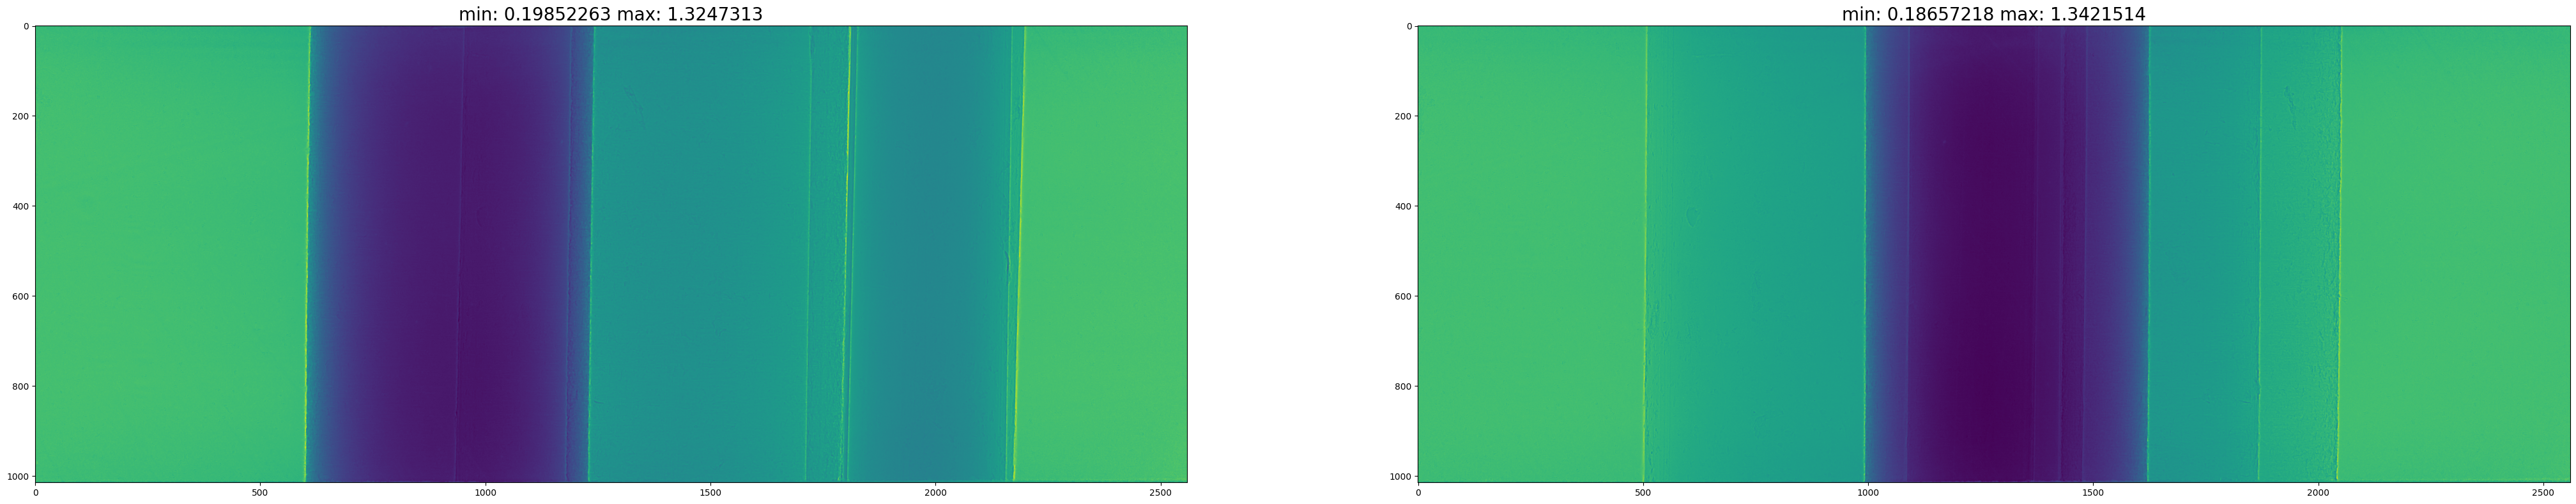

torch.Size([2, 1, 1015, 2560])

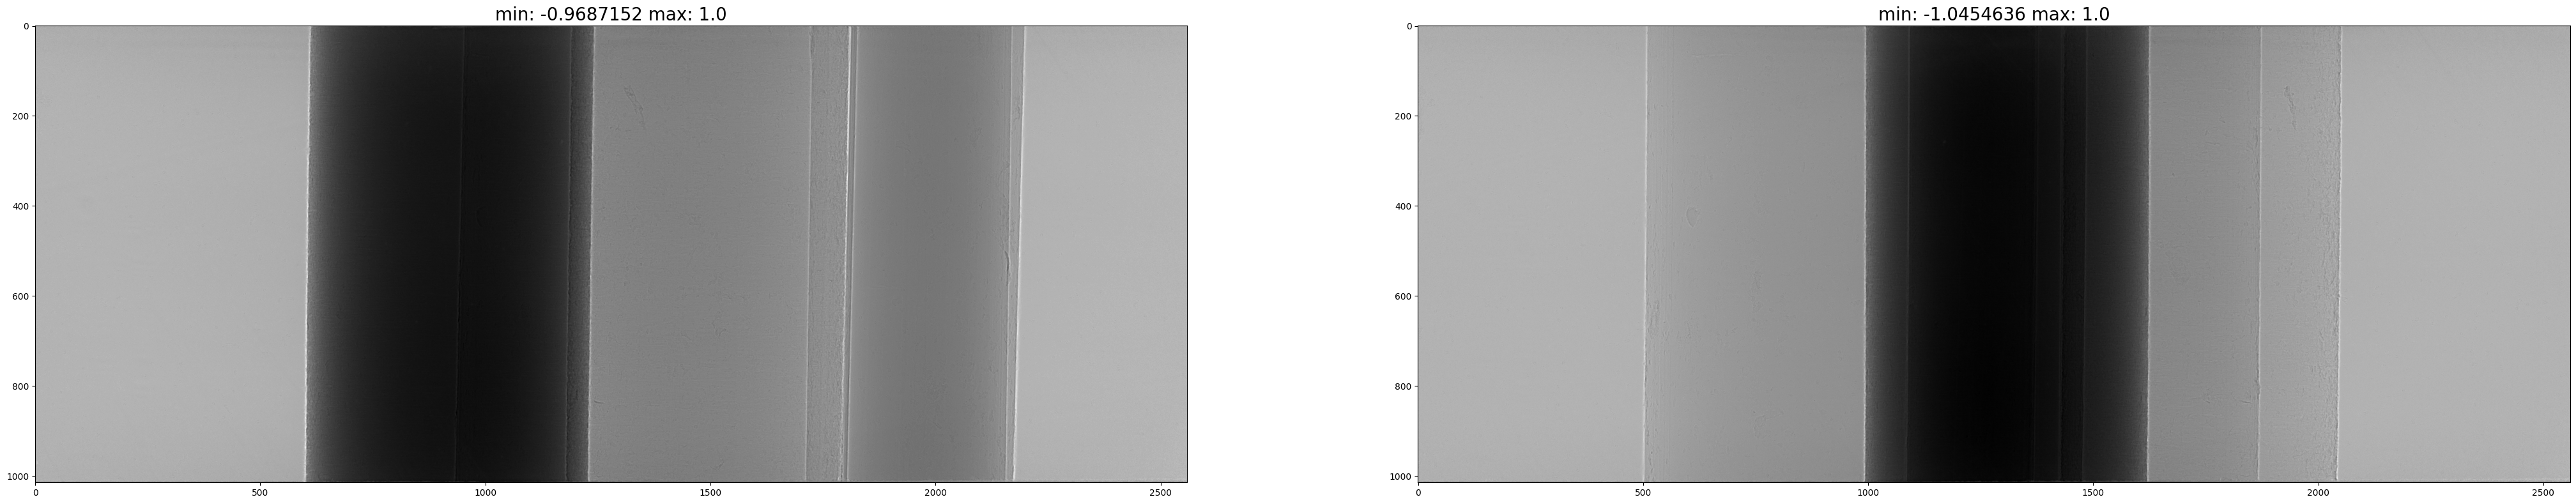

In [5]:
dataset = Dataset(**args)
display(dataset.dims)
dataset.visualize()
normalized_images = dataset.__getitem__()
display(normalized_images.shape)
dataset.normal_visualize(random=False)